# 图像数据增强

数据增强是图像处理中十分常见的操作，在此之前没提到过这个问题是因为 MNIST 数据集本身容量足够，训练集有 60,000 个样本，并且样本内容单一，没有涉及到的手写数字以外的内容。所以你会发现无论是使用包含 Conv2D 的卷积模型还是单纯的 Dense 全连接模型都能得到很好的效果，甚至模型层数都可以控制在10层以内。  

然而实际问题中数据集并不充裕，大多数问题在初期无法一次提供上万张图片。  

最常见的例子就是疫情过后很多单位都搭建了人脸识别门禁，但在此之前甚至没有向你索取或拍摄过你的面部照片，识别系统照样能认出你这张脸，这里面就使用了数据增强。  

还是拿人脸识别门禁举例，模型通过从数据库中提取你工牌上的照片，通过数据增强可以将 1 张照片扩张到 100 张照片，如果你愿意扩张到 10,000 张也是可以的，这样的话就无需要求每个人单独抽出时间去拍摄上百张照片。深度学习中的小样本学习核心也是通过数据增强的方式扩充样本量，这个将在 Advance 文件夹中展开。  

In [1]:
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator     # 导入数据增强工具

import numpy as np
import matplotlib.pyplot as plt

## ImageDataGenerator 

Keras 提供了最基础的图像数据增强工具 ImageDataGenerator 。在当前阶段是能够满足我们需求的。  

* from tensorflow.keras.preprocessing.image image ImageDataGenerator

首先要设置生成器属性。  
这里只讲最常用的几个属性，完整的参数设置可以从 Keras 英文官网中查看：  
* 英文：https://keras.io/api/preprocessing/image/  
* 中文：https://keras.io/zh/preprocessing/image/  

官网文档列举了 22 个可调参数，虽然很全面，但一次性让新手记下这么多参数并不是什么好事，首先当然是因为新手用不到这么多参数，其次是因为过多的参数你不一定记得住，而且容易记混，如果你对一个工具并不熟练，使用的时候是容易打击自己信心的。  

所以，下面我只会提供 6 个最常用的参数，还是拿 MNIST 数据集来举例。  

In [2]:
dataGan = ImageDataGenerator(
    rotation_range=50,          # 1
    width_shift_range=0.3,      # 2
    height_shift_range=0.3,     # 
    shear_range=0.2,            # 3
    zoom_range=0.2,             # 4
    horizontal_flip=False,      # 5
    fill_mode='nearest'         # 6
)

|    | 参数名 | 取值范围 | 描述 |   
| ---- | ---- | ---- | ---- |  
| 1 | rotation_range | 0 ~ 180 | 图片旋转角度。之所以被限制到 180 以内是因为超过 180 度就会出现 “上下翻转” |  
| 2 | width_shift_range | -1 ~ +1 | 水平平移比例。图片在水平位置移动的比例，需要配合 fill_mode 参数填充空白部分 |  
|   | height_shift_range | -1 ~ +1 | 竖直平移比例。图片在竖直位置移动的比例。需要配合 fill_mode 参数填充空白部分 |  
| 3 | shear_range | 0 ~ 1 | 剪切强度。图片沿逆时针方向做剪切操作的程度，直观上看就是 “变斜” 了 |  
| 4 | zoom_range | 0 ~ 1 | 随机缩放阈值。这里需要注意，缩放大小实际上是 \[1-zoom_range\] ~ \[1+zoom_range\]，直观效果就是图片变大和变小 |  
| 5 | horizontal_flip | True or False | 水平翻转 |  
| 6 | fill_mode | "constant", "nearest", "reflect", "wrap" | 空白填充模式。只要是进行了变换那一定会出现空白的部分，这个参数用来控制空白部分填充的内容。默认是 "nearest" 用最近的元素填充；"constant" 用常数填充；'reflect' 用镜像方式填充；'wrap' 用不镜像重复的方式填充|  

你可能说这上面一共 7 个参数啊，说好的 6 个呢？  

别着急，仔细看这两个参数：
* width_shift_range：水平变化
* height_shift_range： 垂直变化  

他俩我将其归为一类，你能记住水平那一定能记住垂直。  

你可能又会问那第 5 个参数 horizontal_flip （水平翻转）怎么没有配上一个 vertical_flip（竖直翻转）呢？  

原因很简单，你见过底盘朝天开的汽车么？你见过四脚朝天跑的狗么？即便是镜像也是左右镜像，实际生活中很少有上下镜像的需求。  
其实最主要的原因是上下颠倒后的图像语义大概率会发生变化。  

--------------

设想这么一个场景：  
你训练了一个描述图片的网络（输入一个图片，输出对这个图片的描述【实际例子将在 Advance 文件夹中提供】）。  
你给网路提供了一张杯口朝上的照片，网络对其描述是：“这是一个杯口朝上的图片”。  
现在你通过数据增强对其上下翻转了一下，你最初的憧憬是无论杯子怎么变形都能得到 “这是一个杯口朝上的图片” 这句话。  
但网络实际会输出 “这是一个杯口朝下的图片” 。  

你的数据增强并没有让你的网络学到更多杯子的形状，反而让网络得到了另一个类别的描述。  

-------------------

基于上述原因 Keras 干脆在 ImageDataGenerator 里面就没提供上下翻转的参数设置。如果真的需要进行上下翻转可以使用 opencv 或者 numpy 手动扩充数据集后，再使用 ImageDataGenerator 进行增强。

-------------------

## 载入数据

In [3]:
(x_train, y_train), (_, _) = mnist.load_data()

x_train = np.expand_dims(x_train, axis=-1)

因为 ImageDataGenerator 是面向所有图像的工具，常见图像通常是 3 通道的 RGB 图，而 MNIST 没有指明第三个通道，所以需要用 np.expand_dims 来扩张一个通道给生成器指明。

## 生成数据

batch_size：单次生成多少的数据，这里为了演示所以每次只让他生成一个图片

In [4]:
imageGenedIter = dataGan.flow(x_train, y_train, batch_size=1)

In [5]:
type(imageGenedIter)

tensorflow.python.keras.preprocessing.image.NumpyArrayIterator

很多博主在这没有提到 dataGan.flow 的返回类型，而是直接根据 Keras 文档一样直接使用了。  

我觉得这样做并不好，因为你都没看见生成的成果就让新手直接用，就好像给你一片药说别管这个药是啥吃就完事了，这导致后期对 Keras 掌握不完备。

实际上 .flow() 函数返回的是一个迭代器，既然是迭代器那通常会提供 .next() 方法来获得内容，实际上就是这么调用的。

In [6]:
images = imageGenedIter.next()
images = np.array(images[0])        # 将 tuple 类型转为 np.array 类型

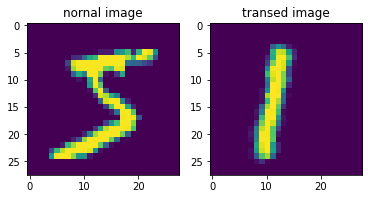

In [7]:
plt.subplot(1,2,1)
plt.title('nornal image')
plt.imshow(x_train[0])
plt.subplot(1,2,2)
plt.title('transed image')
plt.imshow(images[0])

这里为了演示将旋转角度和平移稀疏跳到很大，实际应用的话旋转角度一般在 30 度以内，平移系数是可以大一点的。  

还有一点需要注意，因为 imageGenedIter 是流式方法，所以不一定每次都能配对上你想要的图片。  

后面会告诉大家怎么从流式方法中提取出想要的图片。这里只做一个直观上的感受。

-----------------

## 步入正题

In [8]:
dataGan = ImageDataGenerator(
    rotation_range=50,       
    width_shift_range=0.3,   
    height_shift_range=0.3,    
    shear_range=0.2,           
    zoom_range=0.2,            
    horizontal_flip=False,  
    fill_mode='nearest'    
)

In [9]:
(x_train, y_train), (_, _) = mnist.load_data()

x_train = x_train / 255.0
x_train = np.expand_dims(x_train, axis=-1)
y_train = to_categorical(y_train, num_classes=10)

In [10]:
dataGan.fit(x_train)

Activation('relu')(flowData) ：  
等价于在 Conv2D 中的 activation='relu'，以后的代码为了规范都会将激活函数提出来，这样写能降低忘记在卷积层的概率，同时增加代码可读性。

In [11]:
def covn_maxpool_block(x, filters):
    flowData = x
    for fil in filters:
        flowData = Conv2D(fil, 3, padding='same')(flowData)
        flowData = Activation('relu')(flowData)
        flowData = MaxPooling2D()(flowData)
    return flowData

In [12]:
input_layer = Input(shape=(28, 28, 1))
inter_block = covn_maxpool_block(input_layer, [64, 32, 16])
flatten = Flatten()(inter_block)
dense_layer = Dense(10)(flatten)
out_layer = Activation('softmax')(dense_layer)

In [13]:
model = Model(inputs=input_layer, outputs=out_layer)

In [14]:
model.compile(loss='categorical_crossentropy', metrics='accuracy', optimizer='adam')

## fit() 和 fit_generator 图像增强主要是在这来个函数使用上存在差异

#### 方法一：自动

In [15]:
epochs = 3
batch_sizes = 512

In [16]:
model.fit_generator(dataGan.flow(x_train, y_train, batch_size=batch_sizes),
                   steps_per_epoch=len(x_train) / batch_sizes,
                   epochs=epochs,
                   verbose=1)

c:\users\lucks\.conda\envs\lucks\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
117/117 [==============================] - 14s 109ms/step - loss: 2.1762 - accuracy: 0.1909
Epoch 2/3
117/117 [==============================] - 13s 110ms/step - loss: 1.4253 - accuracy: 0.5238
Epoch 3/3
117/117 [==============================] - 14s 121ms/step - loss: 1.1313 - accuracy: 0.6360


#### 方法二：手动

In [17]:
for e in range(epochs):
    print('epochs:', e)
    batches = 0
    for x_batch, y_batch in dataGan.flow(x_train, y_train, batch_size=batch_sizes):
        model.fit(x_batch, y_batch, batch_size=batch_sizes, verbose=3)
        batches += 1
        if batches >= int(len(x_train) / batch_sizes):
            break
    model.evaluate(x_train, y_train, verbose=1)

epochs: 0
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3912 - accuracy: 0.8968
epochs: 1
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3461 - accuracy: 0.9060
epochs: 2
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2863 - accuracy: 0.9231
